# Expedia Hotel Ranking exercise - Kaggle
Link: https://www.kaggle.com/c/expedia-hotel-ranking-exercise/overview

### Objectives
1.	Using the data in the case study, please perform an analysis on the data to make recommendations for improving performance at Expedia. 
2.	A clear explanation/presentation of your results, code, your approach and reasoning for taking your approach. You should be able to present this as part of your interview

### Plan
* EDA, Data cleaning and Data preparation => to allow better data preparation and potential feature selection for building basic ML models
* Analysis on most correlated input features and correlation of input features with each others
* Get prediction probabilities from Classifiers (probably try LogReg and RF) for each row if hotel booked or not. Based on prediciton label with '1' highest prediction within search (to be confirmed if each searches get a booking or if sometime there is no bookings) OR just sort with highest probabilities first.
* Pull out top X important features from Model

## (A) Import data and EDA 

### Import packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

### Import train and test sets

In [4]:
df_train = pd.read_csv(r'EPS Case study - kaggle\train.csv')
df_test = pd.read_csv(r'EPS Case study - kaggle\test.csv')
print('Shape train set:',df_train.shape)
print('Shape test set:',df_test.shape)

Shape train set: (841115, 47)
Shape test set: (351544, 46)


In [5]:
# high level idea of the columns
pd.options.display.max_columns = None
df_train.head()

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci,srch_co,srch_ci_day,srch_co_day,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,srch_device,srch_currency,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,prop_price_with_discount_usd,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
0,-1046322713,257690,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,5605.0,186.72,3356.0,111.80,0,0,1,3.5,APAC,ASIA,JAPAN,60041,109140,575,4.1,403.0,0,2014-09-13
1,-1046322713,3066218,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,4614.0,153.71,2769.0,92.24,1,0,0,3.0,APAC,ASIA,JAPAN,60041,109140,339,3.6,101.0,0,2014-09-13
2,-1046322713,2271987,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,14026.0,467.25,2821.0,93.98,0,0,1,3.5,APAC,ASIA,JAPAN,60041,109140,179,4.1,1189.0,0,2014-09-13
3,-1046322713,3308025,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,14308.0,476.65,5202.0,173.30,0,0,1,5.0,APAC,ASIA,JAPAN,60041,98278,272,4.8,221.0,0,2014-09-13
4,-1046322713,3222046,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,5445.0,181.39,2589.0,86.25,0,0,0,3.0,APAC,ASIA,JAPAN,60041,109140,198,3.9,702.0,0,2014-09-13


In [6]:
# create copy of raw data if needed
df_train_copy = df_train
df_test_copy = df_test

***
### EDA

#### Handle NULLS - 12 features with NULLs
* fill NULLS with values where logic can be found relatively quickly
* fill NULLs with 'missing info' or '-1' where not logic found

In [7]:
df_train.isnull().sum().sort_values(ascending=False).head(15)

srch_posa_continent                  485248
srch_visitor_wr_member               444878
srch_currency                        134104
srch_visitor_loc_region                 123
prop_price_without_discount_usd          51
prop_price_with_discount_local           51
prop_price_with_discount_usd             51
prop_price_without_discount_local        51
srch_children_cnt                        18
srch_adults_cnt                          18
prop_review_score                         8
prop_review_count                         8
srch_co                                   0
srch_ci                                   0
srch_hcom_destination_id                  0
dtype: int64

In [8]:
# df_test.isnull().sum().sort_values(ascending=False).head(15)

##### srch_posa_continent

In [9]:
df_train['srch_posa_continent'].value_counts()

EUROPE     207181
ASIA       110575
LATAM       32440
OCEANIA      5671
Name: srch_posa_continent, dtype: int64

In [10]:
df_train[df_train['srch_posa_continent'].isnull()]['srch_posa_country'].value_counts()

US        463532
CANADA     21716
Name: srch_posa_country, dtype: int64

In [11]:
df_train['srch_posa_continent'].fillna(value='NORAM', inplace=True)
df_test['srch_posa_continent'].fillna(value='NORAM', inplace=True) # same for test set

##### srch_visitor_wr_member

In [12]:
df_train['srch_visitor_wr_member'].value_counts()

Not Signed In|Returning Visitor|Not FC Member                186401
Not Signed In|New Visitor|Not FC Member                       90491
Signed In|WR Member|Not FC Member                             64361
Signed in - Persistent|WR Member|Not FC Member                49429
Signed in - Persistent|WR Member|Remembered FC Member          3411
Signed In|WR Member|FC Member                                  1077
Signed In|Not WR Member|Not FC Member                           540
Signed in - Persistent|Not WR Member|Not FC Member              379
Signed in - Persistent|Not WR Member|Remembered FC Member       148
Name: srch_visitor_wr_member, dtype: int64

In [13]:
df_train[df_train['srch_visitor_wr_member'].isnull()].head()

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci,srch_co,srch_ci_day,srch_co_day,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,srch_device,srch_currency,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,prop_price_with_discount_usd,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
49,-1072606084,267645,2014-09-12 15:33:08,9bbed0d8-eb2d-42c3-ada4-8f7f3ebe697d,7,UNITED KINGDOM,LDS,LEEDS,NaN,EUROPE,UNITED KINGDOM,549499,-0.127804,51.507538,2014-09-15,2014-09-16,2,3,1,3,1.0,0.0,1,0,0,DESKTOP,NaN,0,0,428.0,695.71,149.0,242.20,0,1,0,4.0,EMEA,EUROPE,UNITED KINGDOM,369,108046,65,4.5,277.0,0,2014-09-12
50,-1072606084,282010,2014-09-12 15:33:08,9bbed0d8-eb2d-42c3-ada4-8f7f3ebe697d,7,UNITED KINGDOM,LDS,LEEDS,NaN,EUROPE,UNITED KINGDOM,549499,-0.127804,51.507538,2014-09-15,2014-09-16,2,3,1,3,1.0,0.0,1,0,0,DESKTOP,NaN,0,0,499.0,811.12,110.0,178.80,0,0,0,3.0,EMEA,EUROPE,UNITED KINGDOM,369,110959,39,3.2,605.0,0,2014-09-12
51,-1072606084,252554,2014-09-12 15:33:08,9bbed0d8-eb2d-42c3-ada4-8f7f3ebe697d,7,UNITED KINGDOM,LDS,LEEDS,NaN,EUROPE,UNITED KINGDOM,549499,-0.127804,51.507538,2014-09-15,2014-09-16,2,3,1,3,1.0,0.0,1,0,0,DESKTOP,NaN,0,0,142.0,230.82,142.0,230.82,0,0,1,3.0,EMEA,EUROPE,UNITED KINGDOM,369,108034,82,4.0,326.0,0,2014-09-12
52,-1072606084,258165,2014-09-12 15:33:08,9bbed0d8-eb2d-42c3-ada4-8f7f3ebe697d,7,UNITED KINGDOM,LDS,LEEDS,NaN,EUROPE,UNITED KINGDOM,549499,-0.127804,51.507538,2014-09-15,2014-09-16,2,3,1,3,1.0,0.0,1,0,0,DESKTOP,NaN,0,0,508.0,825.75,371.0,603.06,0,0,0,5.0,EMEA,EUROPE,UNITED KINGDOM,369,108046,67,4.6,25.0,0,2014-09-12
53,-1072606084,254667,2014-09-12 15:33:08,9bbed0d8-eb2d-42c3-ada4-8f7f3ebe697d,7,UNITED KINGDOM,LDS,LEEDS,NaN,EUROPE,UNITED KINGDOM,549499,-0.127804,51.507538,2014-09-15,2014-09-16,2,3,1,3,1.0,0.0,1,0,0,DESKTOP,NaN,0,0,310.0,503.90,295.0,479.52,0,0,1,4.0,EMEA,EUROPE,UNITED KINGDOM,369,108046,216,4.2,188.0,0,2014-09-12


In [14]:
df_train['srch_visitor_wr_member'].fillna(value='Missing info', inplace=True)
df_test['srch_visitor_wr_member'].fillna(value='Missing info', inplace=True) # same for test set

##### srch_currency

In [15]:
df_train['srch_currency'].value_counts().head()

USD    412926
EUR     53654
GBP     43749
SEK     28876
NOK     20436
Name: srch_currency, dtype: int64

In [16]:
df_train[df_train['srch_currency'].isnull()]['srch_visitor_loc_country'].value_counts().head()

UNITED STATES OF AMERICA    77853
UNITED KINGDOM               8149
JAPAN                        4352
FRANCE                       4146
SOUTH KOREA                  3862
Name: srch_visitor_loc_country, dtype: int64

In [17]:
df_train.groupby(['srch_visitor_loc_country','srch_currency'])['srch_id'].count().head(20)

srch_visitor_loc_country  srch_currency
AFGHANISTAN               GBP                52
                          USD                13
ALAND                     SEK                50
ALBANIA                   EUR                46
ALGERIA                   EUR              5547
                          USD               117
ANGOLA                    EUR                53
                          USD                48
ANTIGUA AND BARBUDA       USD                53
ARGENTINA                 ARS              1210
                          EUR                47
                          USD               610
AUSTRALIA                 AUD              3104
                          GBP                50
                          HKD               152
                          KRW                59
                          TWD                60
                          USD               307
AUSTRIA                   AUD                10
                          EUR               500


In [18]:
df_train['srch_currency'].fillna('Missing info', inplace=True) # decide to fill with 'Missing info' instead of most represented value in the country as believe country field will already bring this information
df_test['srch_currency'].fillna('Missing info', inplace=True) # same for test

##### src_visitor_loc_region

In [19]:
df_train['srch_visitor_loc_region'].value_counts().head(10)

CA           115310
NY            45051
FL            34241
IL            29272
11            24518
TX            22965
NO REGION     21151
AB            17923
MA            17496
AZ            16596
Name: srch_visitor_loc_region, dtype: int64

In [20]:
df_train[df_train['srch_visitor_loc_region'] == '11'].head()

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci,srch_co,srch_ci_day,srch_co_day,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,srch_device,srch_currency,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,prop_price_with_discount_usd,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
910,-239756831,252249,2014-09-02 10:27:25,65ebfebc-bb52-41b6-98a3-eb0eca554d06,1,CHINA,11,BEIJING,Not Signed In|New Visitor|Not FC Member,ASIA,CHINA,1504033,-115.172875,36.114666,2014-09-29,2014-09-30,2,3,1,27,2.0,0.0,1,0,0,DESKTOP,CNY,0,0,362.0,58.93,217.0,35.32,1,0,0,3.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95602,110029,314,3.2,1009.0,0,2014-09-02
911,-239756831,379130,2014-09-02 10:27:25,65ebfebc-bb52-41b6-98a3-eb0eca554d06,1,CHINA,11,BEIJING,Not Signed In|New Visitor|Not FC Member,ASIA,CHINA,1504033,-115.172875,36.114666,2014-09-29,2014-09-30,2,3,1,27,2.0,0.0,1,0,0,DESKTOP,CNY,0,0,866.0,140.97,301.0,49.00,0,0,0,4.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95602,110030,2100,4.4,7645.0,0,2014-09-02
912,-239756831,250124,2014-09-02 10:27:25,65ebfebc-bb52-41b6-98a3-eb0eca554d06,1,CHINA,11,BEIJING,Not Signed In|New Visitor|Not FC Member,ASIA,CHINA,1504033,-115.172875,36.114666,2014-09-29,2014-09-30,2,3,1,27,2.0,0.0,1,0,0,DESKTOP,CNY,0,0,2311.0,376.18,584.0,95.06,0,0,1,4.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95602,110287,5005,4.1,8627.0,0,2014-09-02
913,-239756831,263444,2014-09-02 10:27:25,65ebfebc-bb52-41b6-98a3-eb0eca554d06,1,CHINA,11,BEIJING,Not Signed In|New Visitor|Not FC Member,ASIA,CHINA,1504033,-115.172875,36.114666,2014-09-29,2014-09-30,2,3,1,27,2.0,0.0,1,0,0,DESKTOP,CNY,0,0,675.0,109.88,86.0,14.00,0,0,0,3.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95602,109153,106,3.2,693.0,0,2014-09-02
914,-239756831,275157,2014-09-02 10:27:25,65ebfebc-bb52-41b6-98a3-eb0eca554d06,1,CHINA,11,BEIJING,Not Signed In|New Visitor|Not FC Member,ASIA,CHINA,1504033,-115.172875,36.114666,2014-09-29,2014-09-30,2,3,1,27,2.0,0.0,1,0,0,DESKTOP,CNY,0,0,1793.0,291.86,903.0,146.99,0,0,1,4.0,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,95602,110287,2916,4.0,6331.0,0,2014-09-02


In [21]:
df_train[df_train['srch_visitor_loc_region'] == '11']['srch_visitor_loc_country'].value_counts()

SOUTH KOREA      17773
CHINA             2241
NORWAY            2021
JAPAN              802
TUNISIA            717
FINLAND            551
PORTUGAL           270
LIECHTENSTEIN       51
ALBANIA             46
MOROCCO             46
Name: srch_visitor_loc_country, dtype: int64

In [22]:
df_train[df_train['srch_visitor_loc_country'] == 'CHINA']['srch_visitor_loc_region'].value_counts()

31    2381
11    2241
44    1153
33     280
32     280
37     245
12     122
13      94
35      59
41      54
61      50
42      37
51      19
21      10
Name: srch_visitor_loc_region, dtype: int64

In [23]:
df_train[df_train['srch_visitor_loc_country'] == 'UNITED STATES OF AMERICA']['srch_visitor_loc_region'].value_counts().count()

52

In [24]:
def loc_region(row):
    if row['srch_visitor_loc_region'] is np.nan:
        return 'not applicable'
    if row['srch_visitor_loc_country'] == 'UNITED STATES OF AMERICA':
        return row['srch_visitor_loc_region']
    return 'not applicable'

## Training
df_train['srch_visitor_loc_region'] = df_train.apply(lambda row: loc_region(row), axis=1)
df_test['srch_visitor_loc_region'] = df_test.apply(lambda row: loc_region(row), axis=1) # same for test

In [25]:
df_train['srch_visitor_loc_country'].value_counts(normalize=True).head(10)

UNITED STATES OF AMERICA    0.550677
UNITED KINGDOM              0.060985
SWEDEN                      0.037066
FRANCE                      0.029045
JAPAN                       0.027738
NORWAY                      0.027110
SOUTH KOREA                 0.026124
CANADA                      0.025290
HONG KONG                   0.021131
BRAZIL                      0.018586
Name: srch_visitor_loc_country, dtype: float64

In [26]:
def loc_country(row):
    if row['srch_visitor_loc_country'] == 'UNITED STATES OF AMERICA':
        return row['srch_visitor_loc_country']
    if row['srch_visitor_loc_country'] == 'UNITED KINGDOM':
        return row['srch_visitor_loc_country']
    if row['srch_visitor_loc_country'] == 'SWEDEN':
        return row['srch_visitor_loc_country']
    if row['srch_visitor_loc_country'] == 'FRANCE':
        return row['srch_visitor_loc_country']
    if row['srch_visitor_loc_country'] == 'JAPAN':
        return row['srch_visitor_loc_country']
    if row['srch_visitor_loc_country'] == 'NORWAY':
        return row['srch_visitor_loc_country']
    if row['srch_visitor_loc_country'] == 'SOUTH KOREA':
        return row['srch_visitor_loc_country']
    if row['srch_visitor_loc_country'] == 'CANADA':
        return row['srch_visitor_loc_country']
    if row['srch_visitor_loc_country'] == 'HONG KONG':
        return row['srch_visitor_loc_country']
    return 'not applicable'

## Training
df_train['srch_visitor_loc_country'] = df_train.apply(lambda row: loc_country(row), axis=1)
df_test['srch_visitor_loc_country'] = df_test.apply(lambda row: loc_country(row), axis=1) # same for test

##### prop_price_without_discount_usd

In [27]:
df_train[df_train['prop_price_without_discount_usd'].isnull()].isnull().sum().sort_values(ascending=False).head() # same rows where all info related to price are missing

prop_price_without_discount_local    51
prop_price_without_discount_usd      51
prop_price_with_discount_local       51
prop_price_with_discount_usd         51
srch_local_date                       0
dtype: int64

In [28]:
df_train[df_train['prop_price_without_discount_usd'].isnull()]['prop_booking_bool'].sum() # properties with no price info are never the ones booked

0

In [29]:
df_train['row_to_remove'] = df_train['prop_price_without_discount_usd'].isnull() * 1 # will remove those rows as missing info and never booker properties - for test set will indicate target as 0 at end of process

df_train['prop_price_without_discount_usd'].fillna(value=-1, inplace=True)
df_train['prop_price_without_discount_local'].fillna(value=-1, inplace=True)
df_train['prop_price_with_discount_usd'].fillna(value=-1, inplace=True)
df_train['prop_price_with_discount_local'].fillna(value=-1, inplace=True)

df_test['prop_price_without_discount_usd'].fillna(value=-1, inplace=True)
df_test['prop_price_without_discount_local'].fillna(value=-1, inplace=True)
df_test['prop_price_with_discount_usd'].fillna(value=-1, inplace=True)
df_test['prop_price_with_discount_local'].fillna(value=-1, inplace=True)

##### srch_children_cnt & # srch_adults_cnt

In [30]:
df_train[df_train['srch_children_cnt'].isnull()]['srch_adults_cnt'].isnull().sum() # same rows where no info for adults as well

18

In [31]:
df_train['srch_children_cnt'].value_counts(normalize=True).head(3)

0.0    0.903810
1.0    0.043567
2.0    0.042341
Name: srch_children_cnt, dtype: float64

In [32]:
df_train['srch_adults_cnt'].value_counts(normalize=True).head(3)

2.0    0.634131
1.0    0.238134
3.0    0.053059
Name: srch_adults_cnt, dtype: float64

In [33]:
df_train['srch_children_cnt'].fillna(value=0, inplace=True) # take more frequent
df_test['srch_children_cnt'].fillna(value=0, inplace=True) # same for test

df_train['srch_adults_cnt'].fillna(value=2, inplace=True) # take more frequent
df_test['srch_adults_cnt'].fillna(value=2, inplace=True) # same for test

##### prop_review_score & prop_review_count

In [34]:
df_train[df_train['prop_review_score'].isnull()]['prop_review_count'].isnull().sum() # same rows for both

8

In [35]:
df_train[df_train['prop_review_count'] == 0]['prop_review_score'].value_counts()

0.000000    5809
4.000000       9
3.539826       6
2.770518       4
3.709885       1
3.662503       1
0.772727       1
Name: prop_review_score, dtype: int64

In [36]:
df_train[df_train['prop_review_count'].isnull()]['prop_booking_bool']

1135      1
76399     0
101203    0
446393    0
630046    1
646261    0
646263    0
647480    0
Name: prop_booking_bool, dtype: int64

In [37]:
df_train['prop_review_count'].fillna(value=0, inplace=True)
df_test['prop_review_count'].fillna(value=0, inplace=True) # same for test

df_train['prop_review_score'].fillna(value=0, inplace=True)
df_test['prop_review_score'].fillna(value=0, inplace=True) # same for test

In [38]:
# shall have no more nulls
df_train.isnull().sum().sum()

0

***
#### Data types

In [39]:
df_train.dtypes
# dates: srch_ci, srch_co, srch_date_time, srch_local_date - might need to be updated if start using
# outside of this looks ok

srch_id                                int64
prop_key                               int64
srch_date_time                        object
srch_visitor_id                       object
srch_visitor_visit_nbr                 int64
srch_visitor_loc_country              object
srch_visitor_loc_region               object
srch_visitor_loc_city                 object
srch_visitor_wr_member                object
srch_posa_continent                   object
srch_posa_country                     object
srch_hcom_destination_id               int64
srch_dest_longitude                  float64
srch_dest_latitude                   float64
srch_ci                               object
srch_co                               object
srch_ci_day                            int64
srch_co_day                            int64
srch_los                               int64
srch_bw                                int64
srch_adults_cnt                      float64
srch_children_cnt                    float64
srch_rm_cn

In [40]:
df_train['srch_date_time'] = pd.to_datetime(df_train['srch_date_time'])
df_train['srch_ci'] = pd.to_datetime(df_train['srch_ci'])
df_train['srch_co'] = pd.to_datetime(df_train['srch_co'])
df_train['srch_local_date'] = pd.to_datetime(df_train['srch_local_date'])

***
#### Input features description
* Get a better understanding of each features
* Remove outliers
* Reduce number of categories when too high cardinality
* Create new features

In [41]:
df_train.nunique()

srch_id                              24013
prop_key                              6330
srch_date_time                       23873
srch_visitor_id                      23101
srch_visitor_visit_nbr                 267
srch_visitor_loc_country                10
srch_visitor_loc_region                 53
srch_visitor_loc_city                 5092
srch_visitor_wr_member                  10
srch_posa_continent                      5
srch_posa_country                       67
srch_hcom_destination_id                10
srch_dest_longitude                     10
srch_dest_latitude                      10
srch_ci                                385
srch_co                                376
srch_ci_day                              7
srch_co_day                              7
srch_los                                27
srch_bw                                370
srch_adults_cnt                         16
srch_children_cnt                        9
srch_rm_cnt                              8
srch_mobile

In [42]:
#sns.pairplot(df_train)

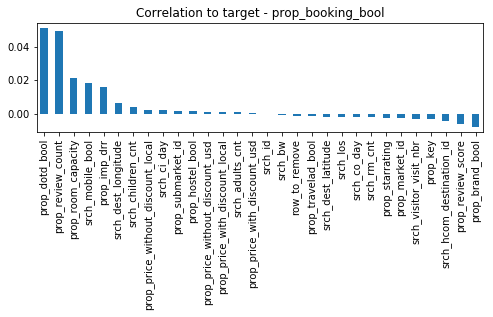

In [43]:
df_train.corr()['prop_booking_bool'].sort_values(ascending=False)[df_train.corr()['prop_booking_bool'].sort_values(ascending=False) < 1].plot(kind='bar', figsize=(8,2))
plt.title('Correlation to target - prop_booking_bool')
plt.show()

* **srch_id:** always one booking per srch_id, seems to be two groups of searches with ~10 properties or ~50 => we will use srch_id at the end to select highest prediction within these feature

In [44]:
df_train.groupby('srch_id')['prop_booking_bool'].sum().value_counts()

1    24013
Name: prop_booking_bool, dtype: int64

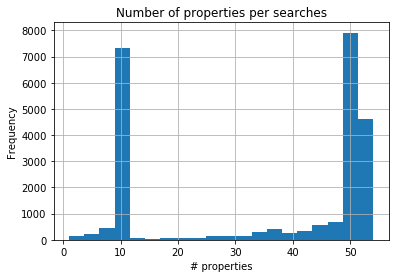

In [45]:
df_train.groupby('srch_id')['prop_key'].count().hist(bins=20)
plt.title('Number of properties per searches')
plt.xlabel('# properties')
plt.ylabel('Frequency')
plt.show()

* **prop_key**

In [46]:
df_train.groupby('prop_key')['srch_id'].count().sort_values(ascending=False).describe()

count    6330.000000
mean      132.877567
std       423.139506
min         1.000000
25%         3.000000
50%        12.000000
75%        69.000000
max      4862.000000
Name: srch_id, dtype: float64

In [47]:
df_train_cvr = df_train.groupby('prop_key')['srch_id','prop_booking_bool'].agg({'srch_id':'count','prop_booking_bool':'sum'})
df_train_cvr['cvr'] = df_train_cvr['prop_booking_bool'] / df_train_cvr['srch_id']
df_train_cvr['cvr'].describe()
# There are big difference in conversion but most property have 0

count    6330.000000
mean        0.031332
std         0.096814
min         0.000000
25%         0.000000
50%         0.000000
75%         0.026316
max         1.000000
Name: cvr, dtype: float64

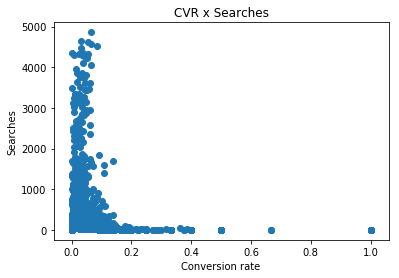

In [48]:
plt.scatter('cvr','srch_id',data=df_train_cvr)
plt.xlabel('Conversion rate')
plt.ylabel('Searches')
plt.title('CVR x Searches')
plt.show()

* **srch_date_time**: one search time per search id => will probably not include

In [49]:
df_train.groupby('srch_id')['srch_date_time'].nunique().sort_values(ascending=False).head()

srch_id
 1808795566    3
-1239745821    3
-700084528     1
-700026614     1
-699701736     1
Name: srch_date_time, dtype: int64

In [50]:
df_train[df_train['srch_id'] == -1239745821]['srch_date_time'].unique()

array(['2014-09-19T18:06:09.000000000', '2014-09-19T18:30:43.000000000',
       '2014-09-19T18:19:46.000000000'], dtype='datetime64[ns]')

In [51]:
df_train['srch_date_time'].min()

Timestamp('2014-08-31 00:01:46')

In [52]:
df_train['srch_date_time'].max()

Timestamp('2014-09-27 23:53:42')

* **srch_visitor_id**

In [53]:
# df_train.groupby('srch_visitor_id')['srch_id'].nunique().plot(kind='bar')

In [54]:
df_train.groupby('srch_visitor_id')['srch_id'].nunique().describe() # most visitors doing only 1 search in data

count    23101.000000
mean         1.039479
std          0.316091
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         25.000000
Name: srch_id, dtype: float64

* **srch_visitor_visit_nbr**

In [55]:
df_train['srch_visitor_visit_nbr'].describe()

count    841115.000000
mean         12.325977
std          31.788936
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max        1082.000000
Name: srch_visitor_visit_nbr, dtype: float64

* **srch_visitor_loc_country**: 

In [56]:
df_train['srch_visitor_loc_country'].value_counts(normalize=True).head() # big share from the US and then very long tail | 151 countries in total

UNITED STATES OF AMERICA    0.550677
not applicable              0.194833
UNITED KINGDOM              0.060985
SWEDEN                      0.037066
FRANCE                      0.029045
Name: srch_visitor_loc_country, dtype: float64

* **srch_visitor_loc_region**

In [57]:
df_train['srch_visitor_loc_region'].value_counts(normalize=True).head() # in data cleaning step have reduced to US regions only

not applicable    0.449323
CA                0.137032
NY                0.053561
FL                0.040652
IL                0.034801
Name: srch_visitor_loc_region, dtype: float64

* **srch_visitor_loc_city**

In [58]:
df_train['srch_visitor_loc_city'].value_counts(normalize=True).head(10) # very long tail

NEW YORK         0.025171
SEOUL            0.019868
LOS ANGELES      0.017070
HONG KONG        0.015992
LAS VEGAS        0.012900
CHICAGO          0.012675
STOCKHOLM        0.010102
TOKYO            0.009850
WASHINGTON       0.008435
SAN FRANCISCO    0.008020
Name: srch_visitor_loc_city, dtype: float64

In [59]:
def loc_city(row):
    if row['srch_visitor_loc_city'] == 'NEW YORK':
        return 'NewYork'
    if row['srch_visitor_loc_city'] == 'SEOUL':
        return 'Seoul'
    if row['srch_visitor_loc_city'] == 'LOS ANGELES':
        return 'LosAngeles'
    if row['srch_visitor_loc_city'] == 'HONG KONG':
        return 'HongKong'
    if row['srch_visitor_loc_city'] == 'lAS VEGAS':
        return 'LasVegas'
    if row['srch_visitor_loc_city'] == 'CHICAGO':
        return 'Chicago'
    return 'not applicable'

## Training
df_train['srch_visitor_loc_city'] = df_train.apply(lambda row: loc_city(row), axis=1)
df_test['srch_visitor_loc_city'] = df_test.apply(lambda row: loc_city(row), axis=1) # same for test

* **srch_visitor_wr_member**

In [60]:
df_train['srch_visitor_wr_member'].value_counts(normalize=True)

Missing info                                                 0.528915
Not Signed In|Returning Visitor|Not FC Member                0.221612
Not Signed In|New Visitor|Not FC Member                      0.107585
Signed In|WR Member|Not FC Member                            0.076519
Signed in - Persistent|WR Member|Not FC Member               0.058766
Signed in - Persistent|WR Member|Remembered FC Member        0.004055
Signed In|WR Member|FC Member                                0.001280
Signed In|Not WR Member|Not FC Member                        0.000642
Signed in - Persistent|Not WR Member|Not FC Member           0.000451
Signed in - Persistent|Not WR Member|Remembered FC Member    0.000176
Name: srch_visitor_wr_member, dtype: float64

* **srch_posa_continent**

In [61]:
df_train['srch_posa_continent'].value_counts(normalize=True)

NORAM      0.576910
EUROPE     0.246317
ASIA       0.131462
LATAM      0.038568
OCEANIA    0.006742
Name: srch_posa_continent, dtype: float64

* **srch_posa_country**

In [62]:
df_train['srch_posa_country'].value_counts(normalize=True).head(10) # very long tail

US                0.551092
UNITED KINGDOM    0.060673
SWEDEN            0.038675
FRANCE            0.035427
JAPAN             0.027493
SOUTH KOREA       0.027227
NORWAY            0.027028
CANADA            0.025818
EMEA              0.021731
HONG KONG         0.019820
Name: srch_posa_country, dtype: float64

In [63]:
df_train['srch_posa_country'].value_counts().count()

67

In [64]:
# keeping top 10
def loc_country_posa(row):
    if row['srch_posa_country'] == 'US':
        return row['srch_posa_country']
    if row['srch_posa_country'] == 'UNITED KINGDOM':
        return row['srch_posa_country']
    if row['srch_posa_country'] == 'SWEDEN':
        return row['srch_posa_country']
    if row['srch_posa_country'] == 'FRANCE':
        return row['srch_posa_country']
    if row['srch_posa_country'] == 'JAPAN':
        return row['srch_posa_country']
    if row['srch_posa_country'] == 'SOUTH KOREA':
        return row['srch_posa_country']
    if row['srch_posa_country'] == 'NORWAY':
        return row['srch_posa_country']
    if row['srch_posa_country'] == 'CANADA':
        return row['srch_posa_country']
    if row['srch_posa_country'] == 'EMEA':
        return row['srch_posa_country']
    if row['srch_posa_country'] == 'HONG KONG':
        return row['srch_posa_country']
    return 'not applicable'

## Training
df_train['srch_posa_country'] = df_train.apply(lambda row: loc_country_posa(row), axis=1)
df_test['srch_posa_country'] = df_test.apply(lambda row: loc_country_posa(row), axis=1) # same for test

In [65]:
df_train['srch_posa_country'].nunique()

11

* **srch_hcom_destination_id**

In [66]:
df_train['srch_hcom_destination_id'].value_counts(normalize=True) # seems to be only on limited destinations

1504033    0.272866
1506246    0.223905
549499     0.129187
1497539    0.109713
504261     0.077318
1404711    0.052527
726784     0.046851
728660     0.036864
759818     0.031849
712491     0.018920
Name: srch_hcom_destination_id, dtype: float64

* **srch_dest_longitude & srch_dest_latitude** - decide to not use as with limited destinations will be able to capture info from country or continent

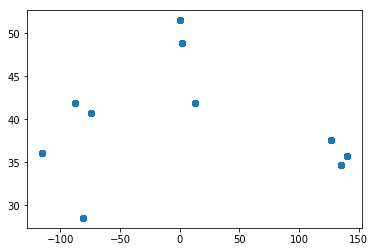

In [67]:
plt.scatter('srch_dest_longitude','srch_dest_latitude',data=df_train)
plt.show()

* **srch_ci & srch_co** - important information capture in other features

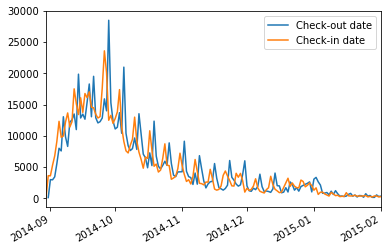

In [68]:
df_train['srch_co'].value_counts().plot(label='Check-out date')
df_train['srch_ci'].value_counts().plot(label='Check-in date')
plt.xlim([datetime.date(2014,8,30), datetime.date(2015,2,1)])
plt.legend()
plt.show()

* **srch_ci_day, srch_co_day, srch_los & srch_bw**

In [69]:
round(df_train['srch_ci_day'].value_counts(normalize=True),3) # most check-ins on weeke-ends => more leisure

6    0.202
7    0.155
5    0.148
4    0.129
1    0.125
2    0.124
3    0.117
Name: srch_ci_day, dtype: float64

In [70]:
round(df_train['srch_co_day'].value_counts(normalize=True),3) # most check-out on mondays (sunday?) 1 = ??

1    0.232
6    0.147
2    0.144
7    0.126
5    0.121
3    0.118
4    0.112
Name: srch_co_day, dtype: float64

In [71]:
round(df_train['srch_los'].value_counts(normalize=True),3).head(10) # 75% stays between 1 and 3 

1     0.332
2     0.267
3     0.181
4     0.093
5     0.048
6     0.025
7     0.021
8     0.008
10    0.007
9     0.006
Name: srch_los, dtype: float64

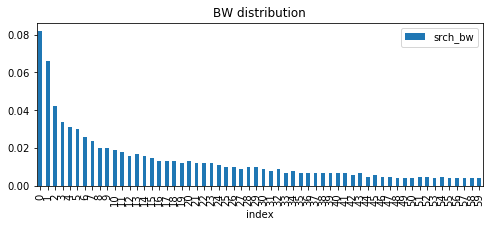

In [72]:
round(df_train['srch_bw'].value_counts(normalize=True),3).reset_index().sort_values(by='index', ascending=True).head(60).set_index('index').plot(kind='bar', figsize=(8,3))
plt.title('BW distribution')
plt.show()

* **srch_adults_cnt, srch_children_cnt & srch_rm_cnt**

In [73]:
df_train['srch_adults_cnt'].value_counts(normalize=True).head()

2.0    0.634139
1.0    0.238129
3.0    0.053058
4.0    0.052915
6.0    0.008149
Name: srch_adults_cnt, dtype: float64

In [74]:
df_train['srch_children_cnt'].value_counts(normalize=True).head()

0.0    0.903812
1.0    0.043566
2.0    0.042340
3.0    0.008629
4.0    0.001216
Name: srch_children_cnt, dtype: float64

In [75]:
df_train['srch_party_size_cnt'] = df_train['srch_adults_cnt'] + df_train['srch_children_cnt']
df_test['srch_party_size_cnt'] = df_test['srch_adults_cnt'] + df_test['srch_children_cnt'] # same for test

In [76]:
df_train['srch_rm_cnt'].value_counts(normalize=True).head()

1    0.916413
2    0.065864
3    0.011057
4    0.003871
5    0.001584
Name: srch_rm_cnt, dtype: float64

* **srch_mobile_bool, srch_mobile_app, srch_device, srch_currency**

In [77]:
round(df_train['srch_mobile_bool'].value_counts(normalize=True).head(),3)

0    0.855
1    0.145
Name: srch_mobile_bool, dtype: float64

In [78]:
round(df_train['srch_mobile_app'].value_counts(normalize=True).head(),3) # always 0 => can be removed

0    1.0
Name: srch_mobile_app, dtype: float64

In [79]:
round(df_train['srch_device'].value_counts(normalize=True).head(),3)

DESKTOP    0.855
TABWEB     0.127
WEB        0.018
Name: srch_device, dtype: float64

In [80]:
df_train[df_train['srch_mobile_bool'] == 1]['srch_device'].value_counts()

TABWEB    106804
WEB        15303
Name: srch_device, dtype: int64

In [81]:
df_train[df_train['srch_device'] == 'TABWEB']['srch_mobile_bool'].value_counts()

1    106804
0       100
Name: srch_mobile_bool, dtype: int64

In [82]:
round(df_train['srch_currency'].value_counts(normalize=True).head(10),3) # keep only info for above 2%

USD             0.491
Missing info    0.159
EUR             0.064
GBP             0.052
SEK             0.034
NOK             0.024
JPY             0.022
CAD             0.021
KRW             0.021
HKD             0.018
Name: srch_currency, dtype: float64

In [83]:
df_train['srch_currency'].nunique()

52

In [84]:
def loc_currency(row):
    if row['srch_currency'] == 'USD':
        return row['srch_currency']
    if row['srch_currency'] == 'EUR':
        return row['srch_currency']
    if row['srch_currency'] == 'GBP':
        return row['srch_currency']
    if row['srch_currency'] == 'SEK':
        return row['srch_currency']
    if row['srch_currency'] == 'NOK':
        return row['srch_currency']
    if row['srch_currency'] == 'CAD':
        return row['srch_currency']
    if row['srch_currency'] == 'KRW':
        return row['srch_currency']
    return 'not applicable'

## Training
df_train['srch_currency'] = df_train.apply(lambda row: loc_currency(row), axis=1)
df_test['srch_currency'] = df_test.apply(lambda row: loc_currency(row), axis=1) # same for test

* **prop_travelad_bool, prop_dotd_bool & prop_imp_drr**

In [85]:
df_train['prop_travelad_bool'].value_counts(normalize=True)

0    0.987779
1    0.012221
Name: prop_travelad_bool, dtype: float64

In [86]:
df_train['prop_dotd_bool'].value_counts(normalize=True)

0    0.996191
1    0.003809
Name: prop_dotd_bool, dtype: float64

In [87]:
df_train['prop_imp_drr'].value_counts(normalize=True)

0    0.574002
1    0.425998
Name: prop_imp_drr, dtype: float64

* **price features** planning to work with usd instead of local

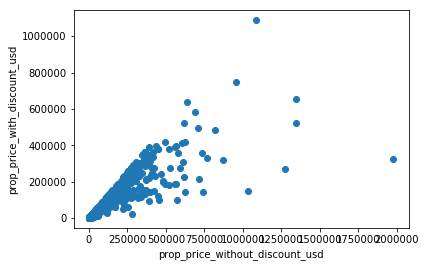

In [88]:
plt.scatter('prop_price_without_discount_usd','prop_price_with_discount_usd', data=df_train)
plt.xlabel('prop_price_without_discount_usd')
plt.ylabel('prop_price_with_discount_usd')
plt.show()

In [89]:
df_train['prop_price_without_discount_usd'].describe()

count    8.411150e+05
mean     4.527365e+02
std      6.864481e+03
min     -1.000000e+00
25%      1.439800e+02
50%      2.729600e+02
75%      4.490000e+02
max      1.976733e+06
Name: prop_price_without_discount_usd, dtype: float64

In [90]:
df_train['row_to_remove'] = ((df_train['prop_price_without_discount_usd'] > 250000) | (df_train['prop_price_with_discount_usd'] > 250000) | (df_train['row_to_remove'] == 1) | (df_train['prop_price_without_discount_usd'] <= 0)) * 1

In [91]:
df_train['row_to_remove'].sum()

186

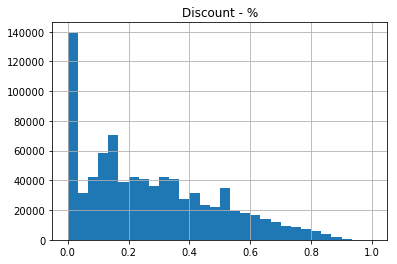

In [92]:
df_train['prop_price_discount'] = abs(df_train['prop_price_with_discount_usd']/df_train['prop_price_without_discount_usd'] - 1)
df_test['prop_price_discount'] = abs(df_test['prop_price_with_discount_usd']/df_test['prop_price_without_discount_usd'] - 1) # same for test
df_train['prop_price_discount'].hist(bins=30)
plt.title('Discount - %')
plt.show()

In [93]:
(df_train['prop_price_without_discount_usd'] <= 0).sum()

53

In [94]:
df_train['prop_price_discount'].fillna(value=0, inplace=True)
df_test['prop_price_discount'].fillna(value=0, inplace=True)

* **property**

In [95]:
df_train['prop_brand_bool'].value_counts(normalize=True)

1    0.664118
0    0.335882
Name: prop_brand_bool, dtype: float64

In [96]:
df_train['prop_starrating'].value_counts(normalize=True)

4.0    0.357610
3.0    0.250739
3.5    0.124336
5.0    0.095178
4.5    0.066080
2.0    0.044833
2.5    0.042225
0.0    0.012594
1.5    0.005818
1.0    0.000586
Name: prop_starrating, dtype: float64

In [97]:
df_train['prop_super_region'].value_counts(normalize=True)

AMER     0.659011
EMEA     0.225422
APAC     0.115564
LATAM    0.000002
Name: prop_super_region, dtype: float64

In [98]:
df_train['prop_continent'].value_counts(normalize=True) # similar as previous - not needed

NORTHAMERICA    0.659011
EUROPE          0.225422
ASIA            0.115564
LATAM           0.000002
Name: prop_continent, dtype: float64

In [99]:
df_train['prop_country'].value_counts(normalize=True)
# df_test['prop_country'].value_counts(normalize=True)

UNITED STATES OF AMERICA    0.659011
UNITED KINGDOM              0.129187
JAPAN                       0.083715
FRANCE                      0.077315
SOUTH KOREA                 0.031849
ITALY                       0.018920
MARTINIQUE                  0.000002
Name: prop_country, dtype: float64

In [100]:
df_train['prop_market_id'].value_counts(normalize=True).head(10) # keep only above 1%

95602    0.272721
95656    0.219763
369      0.129133
95612    0.107887
407      0.073844
95664    0.052541
60039    0.042094
60041    0.034496
90988    0.031815
426      0.018261
Name: prop_market_id, dtype: float64

In [101]:
def loc_market(row):
    if row['prop_market_id'] == 95602:
        return row['prop_market_id']
    if row['prop_market_id'] == 95656:
        return row['prop_market_id']
    if row['prop_market_id'] == 369:
        return row['prop_market_id']
    if row['prop_market_id'] == 95612:
        return row['prop_market_id']
    if row['prop_market_id'] == 407:
        return row['prop_market_id']
    if row['prop_market_id'] == 95664:
        return row['prop_market_id']
    if row['prop_market_id'] == 60039:
        return row['prop_market_id']
    if row['prop_market_id'] == 60041:
        return row['prop_market_id']
    if row['prop_market_id'] == 90988:
        return row['prop_market_id']
    if row['prop_market_id'] == 426:
        return row['prop_market_id']
    return 'not applicable'

## Training
df_train['prop_market_id'] = df_train.apply(lambda row: loc_market(row), axis=1)
df_test['prop_market_id'] = df_test.apply(lambda row: loc_market(row), axis=1) # same for test

In [102]:
df_train['prop_submarket_id'].value_counts(normalize=True).head()

110287    0.134464
96812     0.096414
110029    0.061416
108670    0.058424
96809     0.045764
Name: prop_submarket_id, dtype: float64

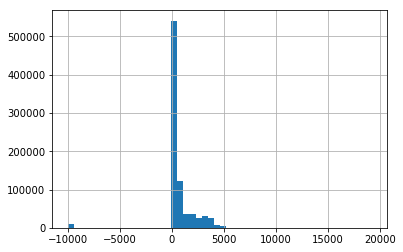

In [103]:
df_train['prop_room_capacity'].hist(bins=50)
plt.show()

In [104]:
(df_train['prop_room_capacity'] == 0).sum()

1770

In [105]:
def loc_room(row):
    if row['prop_room_capacity'] <= 0:
        return -1
    return row['prop_room_capacity']

## Training
df_train['prop_room_capacity'] = df_train.apply(lambda row: loc_room(row), axis=1)
df_test['prop_room_capacity'] = df_test.apply(lambda row: loc_room(row), axis=1) # same for test

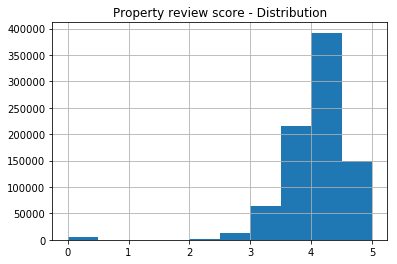

In [106]:
df_train['prop_review_score'].hist()
plt.title('Property review score - Distribution')
plt.show()

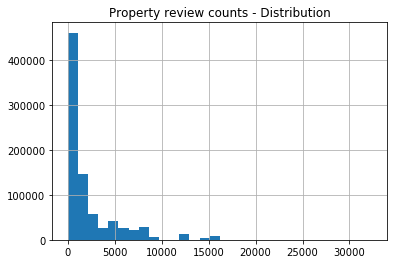

In [107]:
df_train['prop_review_count'].hist(bins=30)
plt.title('Property review counts - Distribution')
plt.show()

In [108]:
df_train['prop_hostel_bool'].value_counts(normalize=True).head()

0    0.997112
1    0.002888
Name: prop_hostel_bool, dtype: float64

* **prop_booking_bool (target)**

In [109]:
df_train.columns

Index(['srch_id', 'prop_key', 'srch_date_time', 'srch_visitor_id',
       'srch_visitor_visit_nbr', 'srch_visitor_loc_country',
       'srch_visitor_loc_region', 'srch_visitor_loc_city',
       'srch_visitor_wr_member', 'srch_posa_continent', 'srch_posa_country',
       'srch_hcom_destination_id', 'srch_dest_longitude', 'srch_dest_latitude',
       'srch_ci', 'srch_co', 'srch_ci_day', 'srch_co_day', 'srch_los',
       'srch_bw', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_mobile_bool', 'srch_mobile_app', 'srch_device', 'srch_currency',
       'prop_travelad_bool', 'prop_dotd_bool',
       'prop_price_without_discount_local', 'prop_price_without_discount_usd',
       'prop_price_with_discount_local', 'prop_price_with_discount_usd',
       'prop_imp_drr', 'prop_booking_bool', 'prop_brand_bool',
       'prop_starrating', 'prop_super_region', 'prop_continent',
       'prop_country', 'prop_market_id', 'prop_submarket_id',
       'prop_room_capacity', 'prop_review_sco

In [110]:
# features classification
label = ['prop_booking_bool','srch_id']
remove_input = ['srch_id','prop_key','srch_date_time','srch_visitor_id','srch_dest_longitude','srch_dest_latitude','srch_ci','srch_co','prop_continent','srch_mobile_app',\
               'prop_price_without_discount_local','prop_price_with_discount_local','prop_submarket_id','srch_loca_date']

keep_input = ['srch_visitor_loc_country','srch_visitor_loc_region','srch_visitor_loc_city','srch_visitor_wr_member','srch_visitor_visit_nbr','srch_posa_continent','srch_posa_country',\
              'srch_hcom_destination_id','srch_ci_day', 'srch_co_day', 'srch_los','srch_bw','srch_adults_cnt', 'srch_children_cnt','srch_party_size_cnt','srch_rm_cnt','srch_mobile_bool','srch_device',\
             'srch_currency','prop_travelad_bool', 'prop_dotd_bool','prop_imp_drr','prop_price_without_discount_usd','prop_price_with_discount_usd','prop_price_discount',\
             'prop_review_score', 'prop_review_count','prop_room_capacity','prop_brand_bool','prop_starrating','prop_super_region','prop_country','prop_hostel_bool','prop_market_id']
keep_input_cont = ['srch_visitor_visit_nbr','srch_los','srch_bw','srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt','srch_party_size_cnt','prop_price_without_discount_usd','prop_price_with_discount_usd',\
                  'prop_price_discount','prop_review_score','prop_room_capacity','prop_review_count','prop_starrating','prop_travelad_bool', 'prop_dotd_bool','prop_imp_drr','prop_brand_bool','prop_hostel_bool']
keep_input_cat = ['srch_visitor_loc_country','srch_visitor_loc_region','srch_visitor_loc_city','srch_visitor_wr_member','srch_posa_continent','srch_posa_country','srch_hcom_destination_id',\
                 'srch_ci_day', 'srch_co_day','srch_mobile_bool','srch_device','srch_currency','prop_super_region',\
                 'prop_country','prop_market_id']

In [111]:
df_train_clean = df_train[~(df_train['row_to_remove'] == 1)]

In [112]:
df_train_clean.reset_index(inplace=True)
df_train_clean.index.max()

840928

In [113]:
df_train_clean.shape

(840929, 51)

***
### Analytics

#### Better Traveler experience - what characteristics of hotels booked?

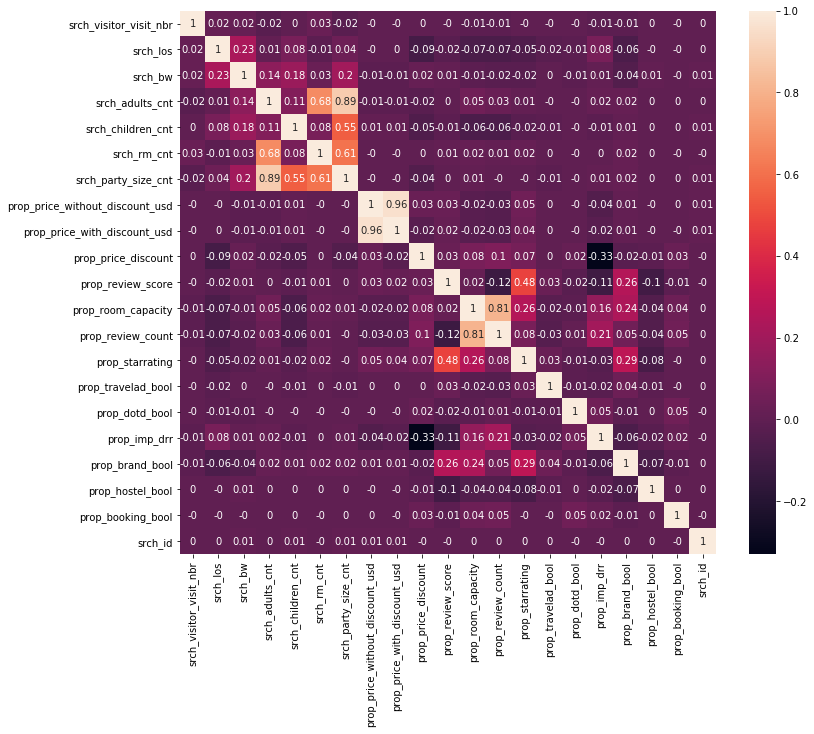

In [114]:
plt.figure(figsize=(12,10))
sns.heatmap(round(df_train_clean[keep_input_cont+label].corr(),2), annot=True)
plt.show()

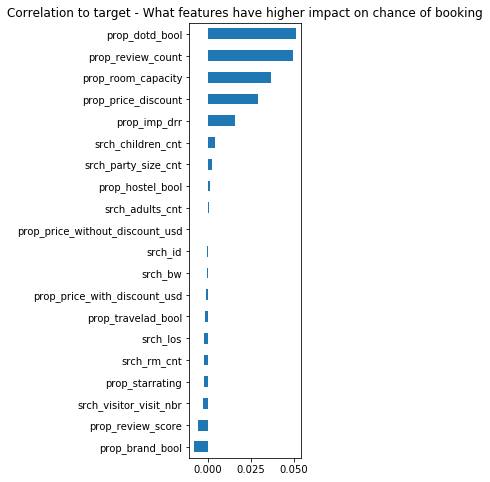

In [115]:
df_train_clean[keep_input_cont+label].corr()['prop_booking_bool'].sort_values(ascending=True)[df_train.corr()['prop_booking_bool'].sort_values(ascending=False) < 1].plot(kind='barh', figsize=(2,8))
plt.title('Correlation to target - What features have higher impact on chance of booking')
plt.show()

#### Highest correlated features to target

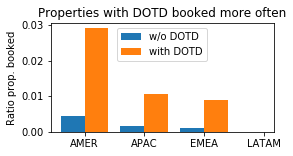

In [116]:
df_dotd = df_train_clean.groupby(['prop_super_region','prop_booking_bool'])['srch_los','prop_dotd_bool'].agg({'srch_los':'count','prop_dotd_bool':'sum'})
df_dotd['dotd_ratio'] = df_dotd['prop_dotd_bool'] /df_dotd['srch_los']
df_dotd_chart = df_dotd.reset_index().pivot(index='prop_super_region', columns='prop_booking_bool', values='dotd_ratio')
X_axis = np.arange(len(df_dotd_chart.index))
plt.figure(figsize=(4,2))
plt.bar(x=X_axis - 0.2,height=df_dotd_chart[0], width=0.4, label='w/o DOTD')
plt.bar(x=X_axis + 0.2,height=df_dotd_chart[1], width=0.4, label='with DOTD')
plt.xticks(X_axis, df_dotd_chart.index)
plt.ylabel('Ratio prop. booked')
plt.title('Properties with DOTD booked more often')
plt.legend()
plt.show()

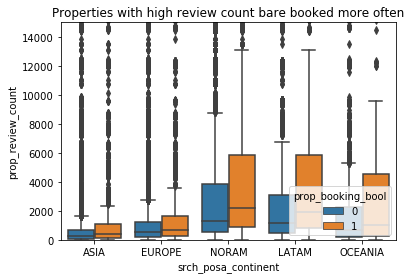

In [117]:
# prop_review_count
#plt.figure(figsize=(4,2))
sns.boxplot(x='srch_posa_continent',y='prop_review_count', hue='prop_booking_bool',data=df_train_clean)
plt.ylim(0,15000)
plt.title('Properties with high review count bare booked more often')
plt.show()

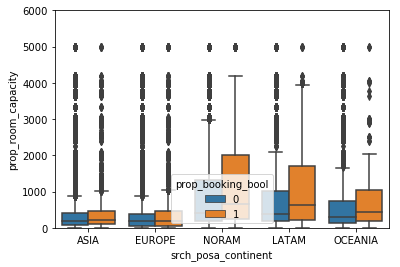

In [118]:
# prop_room_capacity
sns.boxplot(x='srch_posa_continent',y='prop_room_capacity', hue='prop_booking_bool',data=df_train_clean)
plt.ylim(0,6000)
plt.show()

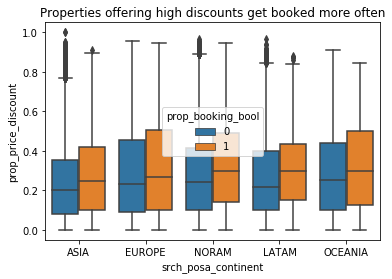

In [119]:
# prop_price_discount
sns.boxplot(x='srch_posa_continent',y='prop_price_discount', hue='prop_booking_bool',data=df_train_clean)
plt.title('Properties offering high discounts get booked more often')
plt.show()

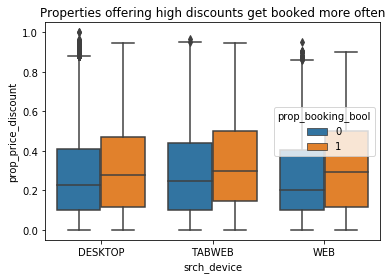

In [120]:
sns.boxplot(x='srch_device',y='prop_price_discount', hue='prop_booking_bool',data=df_train_clean)
plt.title('Properties offering high discounts get booked more often')
plt.show()

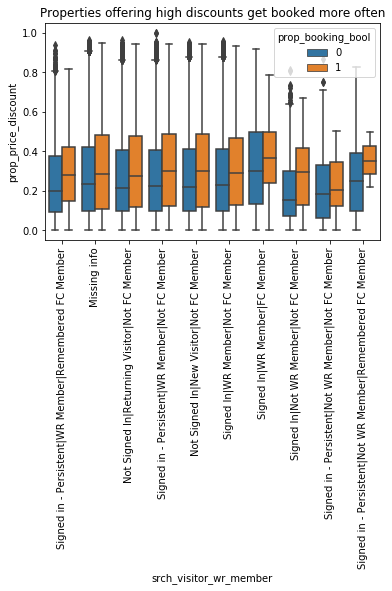

In [121]:
sns.boxplot(x='srch_visitor_wr_member',y='prop_price_discount', hue='prop_booking_bool',data=df_train_clean)
plt.title('Properties offering high discounts get booked more often')
plt.xticks(rotation=90)
plt.show()

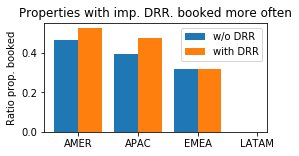

In [122]:
df_imp_drr = df_train_clean.groupby(['prop_super_region','prop_booking_bool'])['srch_los','prop_imp_drr'].agg({'srch_los':'count','prop_imp_drr':'sum'})
df_imp_drr['drr_ratio'] = df_imp_drr['prop_imp_drr'] /df_imp_drr['srch_los']
df_imp_drr_chart = df_imp_drr.reset_index().pivot(index='prop_super_region', columns='prop_booking_bool', values='drr_ratio')
X_axis = np.arange(len(df_imp_drr_chart.index))
plt.figure(figsize=(4,2))
plt.bar(x=X_axis - 0.2,height=df_imp_drr_chart[0], width=0.4, label='w/o DRR')
plt.bar(x=X_axis + 0.2,height=df_imp_drr_chart[1], width=0.4, label='with DRR')
plt.xticks(X_axis, df_imp_drr_chart.index)
plt.ylabel('Ratio prop. booked')
plt.title('Properties with imp. DRR. booked more often')
plt.legend()
plt.show()

#### High correlated features to each-others

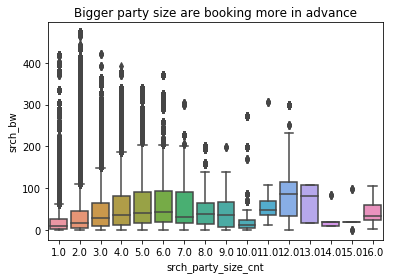

In [123]:
# party_size to srch_bw => the bigger the number of persons trabeller the bigger the BW
sns.boxplot(x='srch_party_size_cnt',y='srch_bw',data=df_train_clean)
#plt.ylim(0,15000)
plt.title('Bigger party size are booking more in advance')
plt.show()

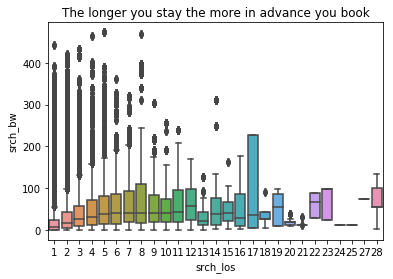

In [124]:
# LOS x BW => the longer you will stay the more in advance you will book
sns.boxplot(x='srch_los',y='srch_bw',data=df_train_clean)
#plt.ylim(0,15000)
plt.title('The longer you stay the more in advance you book')
plt.show()

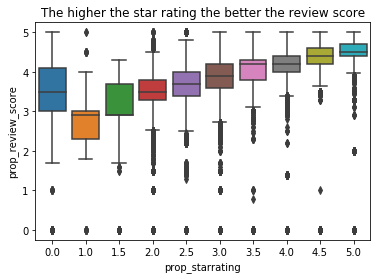

In [125]:
# Star rating x review scores => the higher the star rating the better the review score
sns.boxplot(x='prop_starrating',y='prop_review_score',data=df_train_clean)
#plt.ylim(0,15000)
plt.title('The higher the star rating the better the review score')
plt.show()

***
## (B) ML basic predictive models

### Input features

In [126]:
# categorical variable 
df_train_encoded = pd.get_dummies(df_train_clean[keep_input_cat], columns=keep_input_cat)
print('Train categorical shape:',df_train_encoded.shape)
# same for test
df_test_encoded = pd.get_dummies(df_test[keep_input_cat], columns=keep_input_cat)
print('Test categorical shape:',df_test_encoded.shape)

Train categorical shape: (840929, 154)
Test categorical shape: (351544, 155)


In [127]:
# continuous variable
# scaler = StandardScaler() change to RobustScaler as StandardScaler is assuming Normal distribution which is not the case here
scaler = RobustScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(X=df_train_clean[keep_input_cont]), columns=keep_input_cont)
print('Train continuous shape:',df_train_scaled.shape)
# same for test
df_test_scaled = pd.DataFrame(scaler.transform(X=df_test[keep_input_cont]), columns=keep_input_cont)
print('Test continuous shape:',df_test_scaled.shape)

Train continuous shape: (840929, 19)
Test continuous shape: (351544, 19)


In [128]:
# input features
df_train_input = df_train_scaled.merge(right=df_train_encoded, how='left', left_index=True, right_index=True)
X_train = df_train_input.values
print('Shape training input arrival:',X_train.shape)
# same for test
df_test_input = df_test_scaled.merge(right=df_test_encoded, how='left', left_index=True, right_index=True)
X_test = df_test_input.values
print('Shape training input arrival:',X_test.shape)

Shape training input arrival: (840929, 173)
Shape training input arrival: (351544, 174)


In [129]:
# arrival set
train_list = df_train_input.columns.tolist()
test_list = df_test_input.columns.tolist()

# identify columns which are in train set but not in test sets
for x in train_list:
    if x in test_list: continue
    else:
        print(x)

srch_visitor_wr_member_Signed in - Persistent|Not WR Member|Remembered FC Member


In [130]:
df_test_input_reindex = df_test_input.reindex(columns=df_train_input.columns,fill_value=0.0)
X_test_reindex = df_test_input_reindex.values
print('Shape training input arrival:',X_test_reindex.shape)

Shape training input arrival: (351544, 173)


### Output features

In [131]:
y_train = df_train_clean['prop_booking_bool'].values

### Train validation split

In [132]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=18)
X_te = X_test_reindex

In [133]:
print('X_tr:',X_tr.shape)
print('X_va:',X_va.shape)
print('X_te:',X_te.shape)
print('y_tr:',y_tr.shape)
print('y_va:',y_va.shape)

X_tr: (672743, 173)
X_va: (168186, 173)
X_te: (351544, 173)
y_tr: (672743,)
y_va: (168186,)


#### Logistic Regression

In [134]:
logreg = LogisticRegression(multi_class='ovr',solver='liblinear')

In [135]:
logreg.fit(X_tr, y_tr)
#logreg.score(X_va, y_va)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [136]:
# accuracy - imbalanced data set and therefore accuracy not very relevant => f1 score
logreg.score(X_va, y_va)

0.970764510720274

In [137]:
# we will be using probabilities to rank properties
logreg.predict_proba(X_te)

array([[0.97452134, 0.02547866],
       [0.9710846 , 0.0289154 ],
       [0.97305668, 0.02694332],
       ...,
       [0.96538621, 0.03461379],
       [0.96186088, 0.03813912],
       [0.94583856, 0.05416144]])

In [138]:
df_test_final = pd.merge(left=df_test[['srch_id','prop_key']], right=pd.DataFrame(logreg.predict_proba(X_te)), how='left', left_index=True, right_index=True)

In [139]:
df_test_final.head()

,srch_id,prop_key,0,1
0,-1087756044,3075608,0.974521,0.025479
1,-1087756044,242706,0.971085,0.028915
2,-1087756044,247231,0.973057,0.026943
3,-1087756044,258704,0.974473,0.025527
4,-1087756044,3407116,0.972855,0.027145


In [140]:
df_test_final_sorted = df_test_final.sort_values(by=['srch_id',1], ascending=[True,False])

In [141]:
# export to csv - final manioulation for correct format done in csv directly => results: 0.41
df_test_final_sorted.to_csv('df_test_EG_ranking.csv')

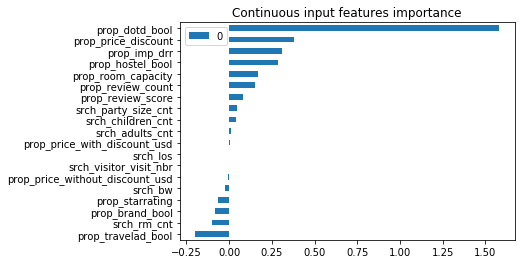

In [142]:
pd.DataFrame(logreg.coef_, columns=df_test_input_reindex.columns)[keep_input_cont].transpose().sort_values(by=0).plot(kind='barh')
plt.title('Continuous input features importance')
plt.show()
# shall be using absolute

In [143]:
# confusion matrix
matrix_logreg = confusion_matrix(y_true=y_va, y_pred=logreg.predict(X_va))
pd.DataFrame(
    matrix_logreg, 
    columns=['pred: no book', 'pred: book'],
    index=['true: no book', 'true: book'])

,pred: no book,pred: book
true: no book,163269,7
true: book,4910,0


In [144]:
# Classification report
print(classification_report(y_true=y_va, y_pred=logreg.predict(X_va), target_names=('no book','book')))

              precision    recall  f1-score   support

     no book       0.97      1.00      0.99    163276
        book       0.00      0.00      0.00      4910

    accuracy                           0.97    168186
   macro avg       0.49      0.50      0.49    168186
weighted avg       0.94      0.97      0.96    168186



In [145]:
# => need to adjust thresholds

### RandomForest

In [146]:
rf = RandomForestClassifier

In [147]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_tr,y_tr)

RandomForestClassifier()

In [148]:
rf.score(X_va, y_va)

0.9707347817297516

In [149]:
# we will be using probabilities to rank properties
rf.predict_proba(X_te)

array([[0.93, 0.07],
       [0.95, 0.05],
       [0.93, 0.07],
       ...,
       [0.93, 0.07],
       [0.94, 0.06],
       [0.93, 0.07]])

In [150]:
df_test_final_rf = pd.merge(left=df_test[['srch_id','prop_key']], right=pd.DataFrame(rf.predict_proba(X_te)), how='left', left_index=True, right_index=True)

In [151]:
df_test_final_rf.head()

,srch_id,prop_key,0,1
0,-1087756044,3075608,0.93,0.07
1,-1087756044,242706,0.95,0.05
2,-1087756044,247231,0.93,0.07
3,-1087756044,258704,0.95,0.05
4,-1087756044,3407116,0.98,0.02


In [152]:
df_test_final_rf_sorted = df_test_final_rf.sort_values(by=['srch_id',1], ascending=[True,False])

In [153]:
# export to csv - final manioulation for correct format done in csv directly => results: 0.44
df_test_final_rf_sorted.to_csv('df_test_EG_ranking_rf.csv')

#### GridSearchCV - RandomForest

In [154]:
# create RandomForest
rf_bis = RandomForestClassifier()
# parameters
balance_rf = [None, 'balanced', 'balanced_subsample']
trees_rf = [3,5,7,9,11]
estimators_rf = [1,3,5,7,9,11,13,15]
param_grid_rf = dict(class_weight=balance_rf, max_depth=trees_rf, n_estimators=estimators_rf)
# define GridSearchCV
scoring = ['precision','recall','average_precision','f1']
grid_rf = GridSearchCV(estimator=rf_bis, param_grid=param_grid_rf, n_jobs=-1, cv=5, scoring=scoring, refit=False, return_train_score=True)
# fit
grid_rf.fit(X_tr, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'max_depth': [3, 5, 7, 9, 11],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15]},
             refit=False, return_train_score=True,
             scoring=['precision', 'recall', 'average_precision', 'f1'])

In [155]:
# Get the results with "cv_results"
grid_rf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_class_weight', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_train_precision', 'split1_train_precision', 'split2_train_precision', 'split3_train_precision', 'split4_train_precision', 'mean_train_precision', 'std_train_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_train_recall', 'split1_train_recall', 'split2_train_recall', 'split3_train_recall', 'split4_train_recall', 'mean_train_recall', 'std_train_recall', 'split0_test_average_precision', 'split1_test_average_precision', 'split2_test_average_precision', 'split3_test_average_precision', 'split4_test_averag

In [156]:
grid_rf.cv_results_['mean_test_f1'][1:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [157]:
cols = ['mean_test_average_precision','mean_train_average_precision','std_test_average_precision',\
        'mean_test_f1','mean_train_f1',\
        'mean_test_recall','mean_train_recall','mean_test_precision','mean_train_precision',\
        'param_max_depth','param_n_estimators','param_class_weight',\
        'mean_fit_time','mean_score_time']
# Delay GridSearchCV
grid_rf_df = pd.DataFrame(grid_rf.cv_results_)[cols].sort_values(by='mean_test_f1', ascending=False)
grid_rf_df.head(20)

,mean_test_average_precision,mean_train_average_precision,std_test_average_precision,mean_test_f1,mean_train_f1,mean_test_recall,mean_train_recall,mean_test_precision,mean_train_precision,param_max_depth,param_n_estimators,param_class_weight,mean_fit_time,mean_score_time
79,0.064739,0.106465,0.001717,0.099617,0.125016,0.487118,0.612694,0.055484,0.069613,11,15,balanced,85.273578,2.535272
118,0.065817,0.105702,0.002636,0.098465,0.121541,0.502356,0.620352,0.054589,0.067379,11,13,balanced_subsample,80.217988,2.167134
119,0.067070,0.109158,0.001697,0.098423,0.122937,0.501991,0.628286,0.054565,0.068141,11,15,balanced_subsample,79.612730,1.800813
117,0.065261,0.104482,0.001152,0.097972,0.120064,0.508432,0.624895,0.054210,0.066413,11,11,balanced_subsample,68.745900,2.037862
78,0.065609,0.103896,0.001836,0.097703,0.121779,0.497120,0.622015,0.054179,0.067501,11,13,balanced,76.157649,2.144201
77,0.064710,0.103186,0.001473,0.096922,0.119012,0.507908,0.625916,0.053584,0.065771,11,11,balanced,64.595062,2.008107
76,0.064998,0.101829,0.003180,0.096461,0.117580,0.512045,0.625144,0.053247,0.064894,11,9,balanced,54.601595,1.765315
69,0.064396,0.082430,0.002308,0.095242,0.105670,0.528644,0.584861,0.052342,0.058090,9,11,balanced,53.832712,1.896502
116,0.062670,0.101774,0.001153,0.095147,0.117264,0.502095,0.620222,0.052555,0.064756,11,9,balanced_subsample,56.300655,1.814934
110,0.064778,0.083848,0.002926,0.095101,0.106546,0.532833,0.596539,0.052216,0.058504,9,13,balanced_subsample,69.422841,2.116933


In [165]:
rf_final = RandomForestClassifier(max_depth=11, n_estimators=15, class_weight='balanced')
rf_final.fit(X_tr,y_tr)
print('Accuracy RF Final:',round(rf_final.score(X_va, y_va),3))

Accuracy RF Final: 0.745


In [164]:
df_test_rf_final = pd.merge(left=df_test[['srch_id','prop_key']], right=pd.DataFrame(rf_final.predict_proba(X_te)), how='left', left_index=True, right_index=True)
df_test_rf_final_sorted = df_test_rf_final.sort_values(by=['srch_id',1], ascending=[True,False])
# export to csv - final manioulation for correct format done in csv directly => results: 0.44
df_test_rf_final_sorted.to_csv('EG_ranking_rf_final.csv')

##### RandForest using 'balanced' class_weight

In [166]:
rf_final = RandomForestClassifier(class_weight='balanced')
rf_final.fit(X_tr,y_tr)
print('Accuracy RF Final:',round(rf_final.score(X_va, y_va),3))

Accuracy RF Final: 0.971


In [167]:
df_test_rf_final = pd.merge(left=df_test[['srch_id','prop_key']], right=pd.DataFrame(rf_final.predict_proba(X_te)), how='left', left_index=True, right_index=True)
df_test_rf_final_sorted = df_test_rf_final.sort_values(by=['srch_id',1], ascending=[True,False])
# export to csv - final manioulation for correct format done in csv directly => results: 0.445
df_test_rf_final_sorted.to_csv('EG_ranking_rf_final.csv')

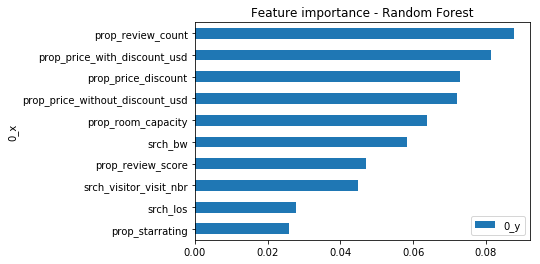

In [194]:
pd.merge(left=pd.DataFrame(df_test_input_reindex.columns), right=pd.DataFrame(rf_final.feature_importances_), left_index=True, right_index=True).set_index('0_x').sort_values(by='0_y', ascending=True).tail(10).plot(kind='barh')
plt.title('Feature importance - Random Forest')
plt.show()